In [1]:
%%capture
%pip install torchvision
%pip install torchsummary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning

Mounted at /content/drive
/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning


In [3]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import itertools
import random
import datetime
import os



from torch.autograd import Function
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torch.autograd import Variable
from torchvision import datasets, transforms
from itertools import zip_longest
from collections import deque


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 27 08:05:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
#model params
params = {
    'epochs':30,
    'num_workers':4,
    'batch_size':32,
    'mul': 100,
    'num_classes':10,
    'channels':3,
    'img_dim':32,
    'device':torch.device('cuda') if torch.cuda.is_available() else 'cpu',
    'fliplr':True,
    'num_epochs':50,
    'decay_epoch':50,
    'lr':0.00002,    #learning rate for generator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}


In [6]:
from torch.utils.data import DataLoader, Subset
import numpy as np
from torchvision import datasets, transforms

# Function to load and preprocess datasets
def load_dataset(dataset_cls, split, root, download, normalize=False, subset_size=None, batch_size=params['batch_size'], transformed=False):
    if transformed:
        transform = transforms.Compose([
            transforms.Resize(int(params['img_dim'])),
            transforms.Grayscale(params['channels']),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*params['channels'], [0.5]*params['channels'])
        ])
        dataset = datasets.ImageFolder(root=root, transform=transform)
    else:
        if dataset_cls == datasets.MNIST or dataset_cls == datasets.USPS:
            dataset = dataset_cls(root=root, train=(split=='train'), download=download, transform=transforms.ToTensor())
        else:
            dataset = dataset_cls(root=root, split=split, download=download, transform=transforms.ToTensor())

        if normalize:
            if dataset_cls == datasets.MNIST or dataset_cls == datasets.USPS:
                print(f"Dataset is : {dataset_cls}")
                transform = transforms.Compose([
                    transforms.Resize(int(params['img_dim'])),
                    transforms.Grayscale(params['channels']),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
                ])
            else:
                print(f"Dataset is : {dataset_cls}")
                transform = transforms.Compose([
                    transforms.Resize(int(params['img_dim'])),
                    transforms.Grayscale(params['channels']),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
                ])
            # Apply the computed normalization
            dataset.transform = transform

    if subset_size:
        indices = np.random.choice(len(dataset), subset_size, replace=False)
        print(dataset.transform)
        dataset = Subset(dataset, indices)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True if split == 'train' else False)
    return loader

# Load MNIST datasets
mnist_trainloader = load_dataset(datasets.MNIST, 'train', './data/', True, normalize=True, subset_size=params['batch_size']*params['mul'])
mnist_testloader = load_dataset(datasets.MNIST, 'test', './data/', True, normalize=True)

# Load SVHN datasets
svhn_trainloader = load_dataset(datasets.SVHN, 'train', './data/', True, normalize=True, subset_size=params['batch_size']*params['mul'])
svhn_testloader = load_dataset(datasets.SVHN, 'test', './data/', True, normalize=True)

# Load USPS datasets
usps_trainloader = load_dataset(datasets.USPS, 'train', './data/', True, normalize=True, subset_size=params['batch_size']*params['mul'])
usps_testloader = load_dataset(datasets.USPS, 'test', './data/', True, normalize=True)

# Create the transformed dataset and dataloader with subset selection
transformed_images_path = 'transformed_mnist_train'
transformed_trainloader = load_dataset(None, 'train', transformed_images_path, False, normalize=True, subset_size=params['batch_size']*params['mul'], transformed=True)


Dataset is : <class 'torchvision.datasets.mnist.MNIST'>
Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Dataset is : <class 'torchvision.datasets.mnist.MNIST'>
Using downloaded and verified file: ./data/train_32x32.mat
Dataset is : <class 'torchvision.datasets.svhn.SVHN'>
Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Using downloaded and verified file: ./data/test_32x32.mat
Dataset is : <class 'torchvision.datasets.svhn.SVHN'>
Dataset is : <class 'torchvision.datasets.usps.USPS'>
Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Dataset is : <class 'tor

### Second Try DANN

In [ ]:
def visualize(encoder, training_mode):
    # Draw 512 samples in test_data
    source_test_loader = svhn_testloader
    target_test_loader = mnist_testloader

    # Get source_test samples
    source_label_list = []
    source_img_list = []
    for i, test_data in enumerate(source_test_loader):
        if i >= 16:  # to get only 512 samples
            break
        img, label = test_data
        label = label.numpy()
        img = img.cuda()
        # img = torch.cat((img, img, img), 1)  # MNIST channel 1 -> 3
        source_label_list.append(label)
        source_img_list.append(img)

    source_img_list = torch.stack(source_img_list)
    source_img_list = source_img_list.view(-1, 3, 32, 32)

    # Get target_test samples
    target_label_list = []
    target_img_list = []
    for i, test_data in enumerate(target_test_loader):
        if i >= 16:
            break
        img, label = test_data
        label = label.numpy()
        img = img.cuda()
        # img = img.repeat(1, 3, 1, 1)
        target_label_list.append(label)
        target_img_list.append(img)

    target_img_list = torch.stack(target_img_list)
    target_img_list = target_img_list.view(-1, 3, 32, 32)

    # Stack source_list + target_list
    combined_label_list = source_label_list
    combined_label_list.extend(target_label_list)
    combined_img_list = torch.cat((source_img_list, target_img_list), 0)

    source_domain_list = torch.zeros(512).type(torch.LongTensor)
    target_domain_list = torch.ones(512).type(torch.LongTensor)
    combined_domain_list = torch.cat((source_domain_list, target_domain_list), 0).cuda()

    print("Extracting features to draw t-SNE plot...")
    combined_feature = encoder(combined_img_list)  # combined_feature : 1024,2352

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    dann_tsne = tsne.fit_transform(combined_feature.detach().cpu().numpy())

    print('Drawing t-SNE plot ...')
    plot_embedding(dann_tsne, combined_label_list, combined_domain_list, training_mode)

def plot_embedding(X, y, d, training_mode):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    y = list(itertools.chain.from_iterable(y))
    y = np.asarray(y)

    plt.figure(figsize=(10, 10))
    for i in range(len(d)):  # X.shape[0] : 1024
        # plot colored number
        if d[i] == 0:
            colors = (0.0, 0.0, 1.0, 1.0)
        else:
            colors = (1.0, 0.0, 0.0, 1.0)
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=colors,
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])

    save_folder = 'saved_plot'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    fig_name = 'saved_plot/' + str(training_mode) + '.png'
    plt.savefig(fig_name)
    print('{} has been successfully saved!'.format(fig_name))

class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


def save_model(encoder, classifier, discriminator, training_mode):
    print('Saving models ...')
    save_folder = 'trained_models'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    torch.save(encoder.state_dict(), 'trained_models/encoder_' + str(training_mode) + '.pt')
    torch.save(classifier.state_dict(), 'trained_models/classifier_' + str(training_mode) + '.pt')

    if training_mode == 'dann':
        torch.save(discriminator.state_dict(), 'trained_models/discriminator_' + str(training_mode) + '.pt')

    print('The model has been successfully saved!')


def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer


def set_model_mode(mode='train', models=None):
    for model in models:
        if mode == 'train':
            model.train()
        else:
            model.eval()

class Extractor(nn.Module):
    def __init__(self):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        x = self.extractor(x)
        x = x.view(-1, 3 * 32 * 32)
        return x


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3 * 32 * 32, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(in_features=3 * 32 * 32, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2)
        )

    def forward(self, input_feature, alpha):
        reversed_input = ReverseLayerF.apply(input_feature, alpha)
        x = self.discriminator(reversed_input)
        return x

In [ ]:
import torch
import numpy as np


def tester(encoder, classifier, discriminator, source_test_loader, target_test_loader, training_mode):
    encoder.cuda()
    classifier.cuda()
    set_model_mode('eval', [encoder, classifier])

    if training_mode == 'DANN':
        discriminator.cuda()
        set_model_mode('eval', [discriminator])
        domain_correct = 0

    source_correct = 0
    target_correct = 0

    for batch_idx, (source_data, target_data) in enumerate(zip(source_test_loader, target_test_loader)):
        p = float(batch_idx) / len(source_test_loader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Process source and target data
        source_image, source_label = process_data(source_data, expand_channels=False)
        target_image, target_label = process_data(target_data)

        # Compute source and target predictions
        source_pred = compute_output(encoder, classifier, source_image, alpha=None)
        target_pred = compute_output(encoder, classifier, target_image, alpha=None)

        # Update correct counts
        source_correct += source_pred.eq(source_label.data.view_as(source_pred)).sum().item()
        target_correct += target_pred.eq(target_label.data.view_as(target_pred)).sum().item()

        if training_mode == 'DANN':
            # Process combined images for domain classification
            combined_image = torch.cat((source_image, target_image), 0)
            domain_labels = torch.cat((torch.zeros(source_label.size(0), dtype=torch.long),
                                       torch.ones(target_label.size(0), dtype=torch.long)), 0).cuda()

            # Compute domain predictions
            domain_pred = compute_output(encoder, discriminator, combined_image, alpha=alpha)
            domain_correct += domain_pred.eq(domain_labels.data.view_as(domain_pred)).sum().item()

    source_dataset_len = len(source_test_loader.dataset)
    target_dataset_len = len(target_test_loader.dataset)

    accuracies = {
        "Source": {
            "correct": source_correct,
            "total": source_dataset_len,
            "accuracy": calculate_accuracy(source_correct, source_dataset_len)
        },
        "Target": {
            "correct": target_correct,
            "total": target_dataset_len,
            "accuracy": calculate_accuracy(target_correct, target_dataset_len)
        }
    }

    if training_mode == 'DANN':
        accuracies["Domain"] = {
            "correct": domain_correct,
            "total": source_dataset_len + target_dataset_len,
            "accuracy": calculate_accuracy(domain_correct, source_dataset_len + target_dataset_len)
        }

    print_accuracy(training_mode, accuracies)


def process_data(data, expand_channels=False):
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    if expand_channels:
        images = images.repeat(1, 3, 1, 1)  # Repeat channels to convert to 3-channel images
    return images, labels


def compute_output(encoder, classifier, images, alpha=None):
    features = encoder(images)
    if isinstance(classifier, Discriminator):
        outputs = classifier(features, alpha)  # Domain classifier
    else:
        outputs = classifier(features)  # Category classifier
    preds = outputs.data.max(1, keepdim=True)[1]
    return preds


def calculate_accuracy(correct, total):
    return 100. * correct / total


def print_accuracy(training_mode, accuracies):
    print(f"Test Results on {training_mode}:")
    for key, value in accuracies.items():
        print(f"{key} Accuracy: {value['correct']}/{value['total']} ({value['accuracy']:.2f}%)")

In [ ]:
# Source : 0, Target :1
source_test_loader =  mnist_testloader
target_test_loader = usps_testloader

def source_only(encoder, classifier, source_train_loader, target_train_loader):
    print("Training with only the source dataset")

    classifier_criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(
        list(encoder.parameters()) +
        list(classifier.parameters()),
        lr=0.01, momentum=0.9)

    for epoch in range(params['epochs']):
        print(f"Epoch: {epoch}")
        set_model_mode('train', [encoder, classifier])

        start_steps = epoch * len(source_train_loader)
        total_steps = params['epochs'] * len(target_train_loader)

        for batch_idx, (source_data, target_data) in enumerate(zip(source_train_loader, target_train_loader)):
            source_image, source_label = source_data
            p = float(batch_idx + start_steps) / total_steps

            # source_image = torch.cat((source_image, source_image, source_image), 1)  # MNIST convert to 3 channel
            source_image, source_label = source_image.cuda(), source_label.cuda()  # 32

            optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
            optimizer.zero_grad()

            source_feature = encoder(source_image)

            # Classification loss
            class_pred = classifier(source_feature)
            class_loss = classifier_criterion(class_pred, source_label)

            class_loss.backward()
            optimizer.step()
            if (batch_idx + 1) % 100 == 0:
                total_processed = batch_idx * len(source_image)
                total_dataset = len(source_train_loader.dataset)
                percentage_completed = 100. * batch_idx / len(source_train_loader)
                print(f'[{total_processed}/{total_dataset} ({percentage_completed:.0f}%)]\tClassification Loss: {class_loss.item():.4f}')

        tester(encoder, classifier, None, source_test_loader, target_test_loader, training_mode='Source_only')

    save_model(encoder, classifier, None, 'Source-only')
    visualize(encoder, 'Source-only')

def dann(encoder, classifier, discriminator, source_train_loader, target_train_loader):
    print("Training with the DANN adaptation method")

    classifier_criterion = nn.CrossEntropyLoss().cuda()
    discriminator_criterion = nn.CrossEntropyLoss().cuda()

    optimizer = optim.SGD(
        list(encoder.parameters()) +
        list(classifier.parameters()) +
        list(discriminator.parameters()),
        lr=0.01,
        momentum=0.9)

    for epoch in range(params['epochs']):
        print(f"Epoch: {epoch}")
        set_model_mode('train', [encoder, classifier, discriminator])

        start_steps = epoch * len(source_train_loader)
        total_steps = params['epochs'] * len(target_train_loader)

        for batch_idx, (source_data, target_data) in enumerate(zip(source_train_loader, target_train_loader)):

            source_image, source_label = source_data
            target_image, target_label = target_data

            p = float(batch_idx + start_steps) / total_steps
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            source_image, source_label = source_image.cuda(), source_label.cuda()
            target_image, target_label = target_image.cuda(), target_label.cuda()
            combined_image = torch.cat((source_image, target_image), 0)

            optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
            optimizer.zero_grad()

            combined_feature = encoder(combined_image)
            source_feature = encoder(source_image)

            # 1.Classification loss
            class_pred = classifier(source_feature)
            class_loss = classifier_criterion(class_pred, source_label)

            # 2. Domain loss
            domain_pred = discriminator(combined_feature, alpha)

            domain_source_labels = torch.zeros(source_label.shape[0]).type(torch.LongTensor)
            domain_target_labels = torch.ones(target_label.shape[0]).type(torch.LongTensor)
            domain_combined_label = torch.cat((domain_source_labels, domain_target_labels), 0).cuda()
            domain_loss = discriminator_criterion(domain_pred, domain_combined_label)

            total_loss = class_loss + domain_loss
            total_loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print('[{}/{} ({:.0f}%)]\tTotal Loss: {:.4f}\tClassification Loss: {:.4f}\tDomain Loss: {:.4f}'.format(
                    batch_idx * len(target_image), len(target_train_loader.dataset), 100. * batch_idx / len(target_train_loader), total_loss.item(), class_loss.item(), domain_loss.item()))

        tester(encoder, classifier, discriminator, source_test_loader, target_test_loader, training_mode='DANN')

    save_model(encoder, classifier, discriminator, 'DANN')
    visualize(encoder, 'DANN')

Training with only the source dataset
Epoch: 0
[3168/3200 (99%)]	Classification Loss: 2.3009
Test Results on Source_only:
Source Accuracy: 220/10000 (2.20%)
Target Accuracy: 200/2007 (9.97%)
Epoch: 1
[3168/3200 (99%)]	Classification Loss: 2.2790
Test Results on Source_only:
Source Accuracy: 237/10000 (2.37%)
Target Accuracy: 267/2007 (13.30%)
Epoch: 2
[3168/3200 (99%)]	Classification Loss: 2.1403
Test Results on Source_only:
Source Accuracy: 245/10000 (2.45%)
Target Accuracy: 381/2007 (18.98%)
Epoch: 3
[3168/3200 (99%)]	Classification Loss: 1.7950
Test Results on Source_only:
Source Accuracy: 245/10000 (2.45%)
Target Accuracy: 507/2007 (25.26%)
Epoch: 4
[3168/3200 (99%)]	Classification Loss: 0.6763
Test Results on Source_only:
Source Accuracy: 242/10000 (2.42%)
Target Accuracy: 505/2007 (25.16%)
Epoch: 5
[3168/3200 (99%)]	Classification Loss: 0.5908
Test Results on Source_only:
Source Accuracy: 262/10000 (2.62%)
Target Accuracy: 542/2007 (27.01%)
Epoch: 6
[3168/3200 (99%)]	Classificati

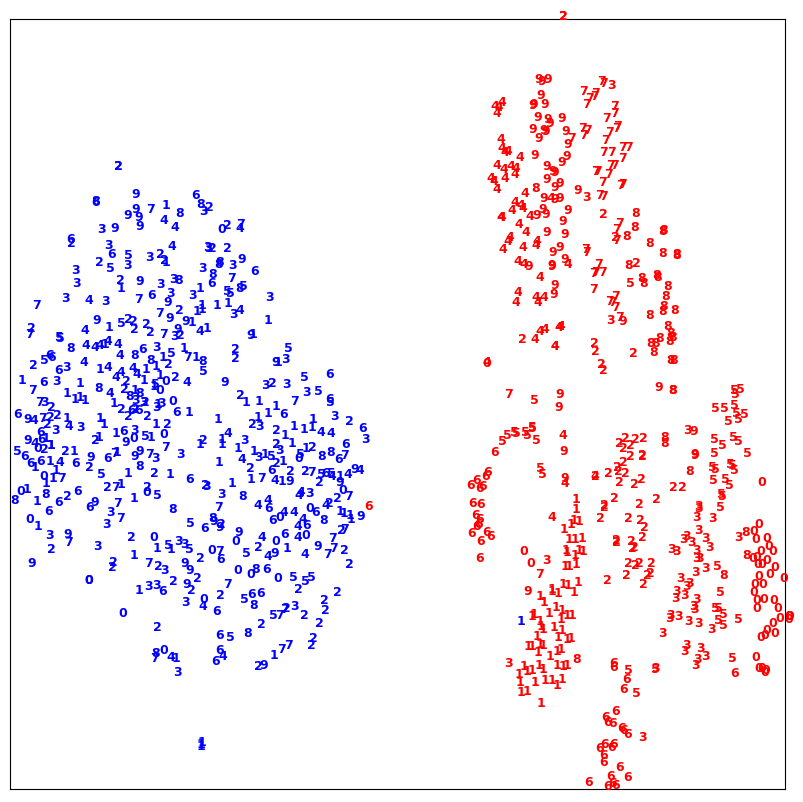

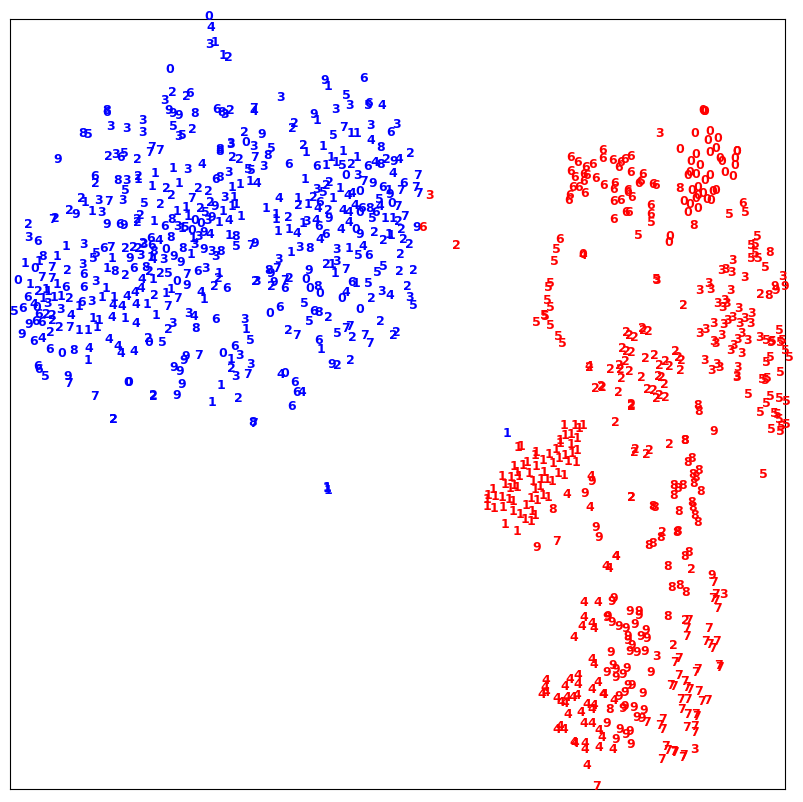

In [ ]:
def main():
    source_train_loader = transformed_trainloader
    target_train_loader = usps_trainloader

    if torch.cuda.is_available():
        encoder = Extractor().cuda()
        classifier = Classifier().cuda()
        discriminator = Discriminator().cuda()

        source_only(encoder, classifier, source_train_loader, target_train_loader)
        dann(encoder, classifier, discriminator, source_train_loader, target_train_loader)
    else:
        print("No GPUs available.")


if __name__ == "__main__":
    main()